In [35]:
import pandas as pd

mnist_training_data = pd.read_csv("data/train.csv")

X: pd.DataFrame = mnist_training_data.drop('label', axis=1)
y: pd.DataFrame = mnist_training_data.label

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)

In [37]:
X_train.shape

(26880, 784)

In [38]:
from keras.backend import clear_session

clear_session()

In [39]:
from keras.models import Sequential
from keras.layers import Dense, Rescaling

model = Sequential([
    Rescaling(1. / 255, input_shape=[784]),
    Dense(300, activation="relu"),
    Dense(100, activation="relu"),
    Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [40]:
from keras.callbacks import TensorBoard, EarlyStopping
import datetime

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = EarlyStopping(patience=10, restore_best_weights=True)

In [41]:
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val),
                    callbacks=[tensorboard_callback, early_stopping_callback])

Epoch 1/200
840/840 [==============================] - 1s 851us/step - loss: 0.8396 - accuracy: 0.7876 - val_loss: 0.4164 - val_accuracy: 0.8844
Epoch 2/200
840/840 [==============================] - 1s 728us/step - loss: 0.3606 - accuracy: 0.8999 - val_loss: 0.3221 - val_accuracy: 0.9107
Epoch 3/200
840/840 [==============================] - 1s 735us/step - loss: 0.2957 - accuracy: 0.9168 - val_loss: 0.2793 - val_accuracy: 0.9211
Epoch 4/200
840/840 [==============================] - 1s 789us/step - loss: 0.2607 - accuracy: 0.9269 - val_loss: 0.2635 - val_accuracy: 0.9241
Epoch 5/200
840/840 [==============================] - 1s 766us/step - loss: 0.2348 - accuracy: 0.9332 - val_loss: 0.2355 - val_accuracy: 0.9350
Epoch 6/200
840/840 [==============================] - 1s 755us/step - loss: 0.2142 - accuracy: 0.9395 - val_loss: 0.2203 - val_accuracy: 0.9374
Epoch 7/200
840/840 [==============================] - 1s 769us/step - loss: 0.1960 - accuracy: 0.9438 - val_loss: 0.2106 - val_ac

In [42]:
# tensorboard --logdir other/kaggle/mnist/logs

In [48]:
model.evaluate(X_test, y_test)

263/263 [==============================] - 0s 596us/step - loss: 0.1003 - accuracy: 0.9724


[0.100255087018013, 0.9723809361457825]

In [49]:
model.save("mnist_kaggle_model.h5")

In [50]:
from keras.models import load_model

loaded_model = load_model("mnist_kaggle_model.h5")

In [51]:
assert model.evaluate(X_test, y_test) == loaded_model.evaluate(X_test, y_test)

263/263 [==============================] - 0s 462us/step - loss: 0.1003 - accuracy: 0.9724


#### Predict data with trained model

In [54]:
X: pd.DataFrame = pd.read_csv("data/test.csv")

In [59]:
mnist_model: Sequential = load_model("mnist_kaggle_model.h5")
predictions = mnist_model.predict(X)

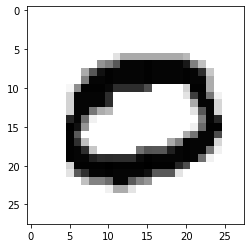

Predicted value is: 0


In [88]:
import numpy as np
from matplotlib import pyplot as plt

random_idx = np.random.randint(0, len(predictions))

example_image = X.iloc[random_idx].to_numpy()
example_image = example_image.reshape(28, 28)

plt.imshow(example_image, cmap="binary")
plt.show()
print("Predicted value is:", np.argmax(predictions[random_idx]))

In [123]:
data = {'ImageId': np.arange(1, len(predictions) + 1), 'Label': np.argmax(predictions, axis=1)}
results_df = pd.DataFrame(data=data).to_csv("results.csv", index=False)